# Link Prediction Baselines
---
ROC AUC and Average Precision computed on Facebook dataset using these link prediction baselines:
1. Adamic-Adar
2. Jaccard Coefficient
3. Preferential Attachment

## 1. Read in Graph Data

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import csv
import pickle

In [37]:
# Read data
with open('./DatasetsPaper/fb-forum-m.csv', 'rb') as f:
    #adj, features = pickle.load(f)
    reader = csv.reader(f)
    m_array = list(reader)
    
#g = nx.Graph(adj)
list_m = [tuple(map(int,x)) for x in m_array]
g = nx.Graph()
g.add_edges_from(list_m)
adj = nx.adjacency_matrix(g)

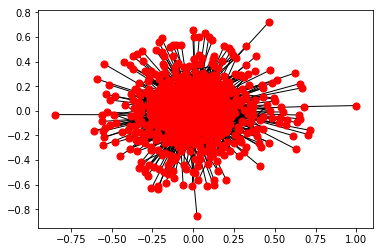

In [38]:
# draw network
nx.draw_networkx(g, with_labels=False, node_size=50, node_color='r')
plt.show()

## 2. Preprocessing/Train-Test Split

In [39]:
from gae.preprocessing import mask_test_edges
np.random.seed(0) # make sure train-test split is consistent between notebooks
adj_sparse = nx.to_scipy_sparse_matrix(g)

# Perform train-test split
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.3, val_frac=.0)
g_train = nx.from_scipy_sparse_matrix(adj_train) # new graph object with only non-hidden edges

In [40]:
# Inspect train/test split
print "Total nodes:", adj_sparse.shape[0]
print "Total edges:", int(adj_sparse.nnz/2) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print "Training edges (positive):", len(train_edges)
print "Training edges (negative):", len(train_edges_false)
print "Validation edges (positive):", len(val_edges)
print "Validation edges (negative):", len(val_edges_false)
print "Test edges (positive):", len(test_edges)
print "Test edges (negative):", len(test_edges_false)

Total nodes: 899
Total edges: 7041
Training edges (positive): 4223
Training edges (negative): 4223
Validation edges (positive): 703
Validation edges (negative): 703
Test edges (positive): 2110
Test edges (negative): 2110


In [41]:
def get_roc_score(edges_pos, edges_neg, score_matrix):
    # Store positive edge predictions, actual values
    preds_pos = []
    pos = []
    for edge in edges_pos:
        preds_pos.append(score_matrix[edge[0], edge[1]]) # predicted score
        pos.append(adj_sparse[edge[0], edge[1]]) # actual value (1 for positive)
        
    # Store negative edge predictions, actual values
    preds_neg = []
    neg = []
    for edge in edges_neg:
        preds_neg.append(score_matrix[edge[0], edge[1]]) # predicted score
        neg.append(adj_sparse[edge[0], edge[1]]) # actual value (0 for negative)
        
    # Calculate scores
    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    return roc_score, ap_score

## 3. Adamic-Adar

In [42]:
# Compute Adamic-Adar indexes from g_train
aa_matrix = np.zeros(adj.shape)
for u, v, p in nx.adamic_adar_index(g_train): # (u, v) = node indices, p = Adamic-Adar index
    aa_matrix[u][v] = p
    aa_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
aa_matrix = aa_matrix / aa_matrix.max()

In [43]:
# Calculate ROC AUC and Average Precision
aa_roc, aa_ap = get_roc_score(test_edges, test_edges_false, aa_matrix)

print 'Adamic-Adar Test ROC score: ', str(aa_roc)
print 'Adamic-Adar Test AP score: ', str(aa_ap)

Adamic-Adar Test ROC score:  0.6466658430852855
Adamic-Adar Test AP score:  0.6370287638826766


## 4. Jaccard Coefficient

In [44]:
# Compute Jaccard Coefficients from g_train
jc_matrix = np.zeros(adj.shape)
for u, v, p in nx.jaccard_coefficient(g_train): # (u, v) = node indices, p = Jaccard coefficient
    jc_matrix[u][v] = p
    jc_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
jc_matrix = jc_matrix / jc_matrix.max()

In [45]:
# Calculate ROC AUC and Average Precision
jc_roc, jc_ap = get_roc_score(test_edges, test_edges_false, jc_matrix)

print 'Jaccard Coefficient Test ROC score: ', str(jc_roc)
print 'Jaccard Coefficient Test AP score: ', str(jc_ap)

Jaccard Coefficient Test ROC score:  0.6324647918959592
Jaccard Coefficient Test AP score:  0.5654517159022556


## 5. Preferential Attachment

In [46]:
# Calculate, store Adamic-Index scores in array
pa_matrix = np.zeros(adj.shape)
for u, v, p in nx.preferential_attachment(g_train): # (u, v) = node indices, p = Jaccard coefficient
    pa_matrix[u][v] = p
    pa_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
pa_matrix = pa_matrix / pa_matrix.max()

In [47]:
# Calculate ROC AUC and Average Precision
pa_roc, pa_ap = get_roc_score(test_edges, test_edges_false, pa_matrix)

print 'Preferential Attachment Test ROC score: ', str(pa_roc)
print 'Preferential Attachment Test AP score: ', str(pa_ap)

Preferential Attachment Test ROC score:  0.8408352238269581
Preferential Attachment Test AP score:  0.8223801394906798
